A. Loading data
1. Load coordinates in map
2. Load lakes
3. Load lakes sent to Denis
4. Load hydrolakes
5. Load all the lakes
B. Load available time series (ground data)
1. Load argentina's Time series
2. Load loccss time series
3. Load other time series (Brazil)
4. Load VS time series 
C. Plot time series with altimeter data


In [36]:
#Import 
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import numpy as np
from shapely.geometry import Point
import fiona
import folium
import os
import gzip
import glob
import shutil
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
current_dir=os.getcwd()
current_dir

'/home/angelica/Documents/py_linux/pylocss/src'

In [60]:
#!/usr/bin/env python
# encoding: utf-8
#Sylvain functions
""" Python3 script showing how to load altimetry time series computed from
    GDR altimetry files using AlTiS software
"""


import os
import time as tm
import numpy as np
from pylab import plt
from datetime import datetime as dt


def decimalyear2yearmonthdayhour(decimaltime_curr):
    '''
    Function to convert time vector in decimal year to
    correponding year, month, day and hour for each date
    '''
    # Compute year for the input date in decimal year
    year_curr = int(np.floor(decimaltime_curr))
    # Compute number of days in current year for the input date
    #  (01 January = day 1)
    start_yearcurr = dt(year=year_curr, month=1, day=1)
    start_nextyear = dt(year=year_curr+1, month=1, day=1)
    totnumdays_yearcurr = (tm.mktime(start_nextyear.timetuple()) -
                           tm.mktime(start_yearcurr.timetuple()))/(24.0*3600.0)
    numdays_decimaltimecurr = int(np.floor((decimaltime_curr-year_curr) *
                                           totnumdays_yearcurr)) + 1
    # Compute month for the input date in decimal year
    ydm_curr = dt.strptime(str(year_curr)+" "+str(numdays_decimaltimecurr),
                           "%Y %j")
    month_curr = ydm_curr.month
    day_curr = ydm_curr.day
    # Compute hour for the input date in decimal year
    #  (numdays_decimaltimecurr-1 because 01 January
    #  19 hour is actualy day 0 from starting year + 19 hours)
    hour_curr = int((decimaltime_curr-year_curr -
                     float(numdays_decimaltimecurr-1)/totnumdays_yearcurr) *
                    totnumdays_yearcurr*24)
    return (year_curr, month_curr, day_curr, hour_curr)


def yearday2decimalyear(year_curr, day_curr):
    '''
    Function to convert date defined by its year (year_curr)
    and the number of days elapsed since the begining of the
    year (day_curr), with the covention that the first day is
    day 1 (and not 0) and the last day of the year is day 366
    for leap year and 365 for others.
    For example, February 3rd, 2019 corresponds to:
    year_curr = 2019
    day_curr = 34
    '''
    start_yearcurr = dt(year=int(year_curr), month=1, day=1)
    start_nextyear = dt(year=int(year_curr)+1, month=1, day=1)
    totnumdays_yearcurr = (tm.mktime(start_nextyear.timetuple()) -
                           tm.mktime(start_yearcurr.timetuple()))/(24.0*3600.0)
    decimalyear = year_curr + float(day_curr)/totnumdays_yearcurr
    return (decimalyear)


def yearmonthdayhourminutesec2decimalyear(year_curr, month_curr, day_curr,
                                          hour_curr, minute_curr, sec_curr):
    '''
    Function to convert time vector in year, month, day, hour,
    minute and second to correponding decimal year for each date
    '''
    date_curr = dt(int(year_curr), int(month_curr), int(day_curr),
                   int(hour_curr), int(minute_curr), int(sec_curr))
    dayyear_curr = int(date_curr.strftime("%j"))
    decimaltime_curr = yearday2decimalyear(year_curr, dayyear_curr - 1 +
                                           hour_curr/24.0 +
                                           minute_curr/(24.0*60.0) +
                                           sec_curr/(24.0*60.0*60.0))
    return decimaltime_curr


def load_altis(falti, ncoldate, ncolh, nodataalti=-9999):
    '''
    Function to load altimetry water elevation in AlTiS csv format
    Inputs:
    - falti: AlTiS csv file
    - ncoldate: name of the column with date of each sample time series
    - ncolh: name of the column with water elevation time series
    - nodataalti: no data values in the water elevation time series
    Outputs:
    - alti_year: year of all samples in the time series
    - alti_month: month of all samples in the time series
    - alti_day: day of all samples in the time series
    - alti_hour: hour of all samples in the time series
    - alti_minute: minute of all samples in the time series
    - alti_height: water elevation of all samples in the time series
                   referenced to the mission reference geoid (and not the
                   ellipsoid)
    '''
    # Retrieve in-situ water level file header
    fin = open(falti)
    isheader = fin.readline()
    fin.close()
    isheader_split = (isheader.replace('\n', '')).split(',')
    # Extract water elevation
    patterncol = ncolh
    icolh = [i for i, s in enumerate(isheader_split)
             if patterncol.lower() in s.lower()]
    if len(icolh) == 0:
        print(('Error: no column '+ncolh+' in '+falti))
        alti_height = None
    elif len(icolh) > 1:
        print(('Error: more than one column '+ncolh+' in '+falti))
        alti_height = None
    elif len(icolh) == 1:
        alti_height = np.loadtxt(falti, skiprows=1, delimiter=',',
                                 usecols=[icolh[0]])
    # Get lines with no data values
    ivaliddata = (alti_height > nodataalti).nonzero()
    # Extract date
    patterncol = ncoldate
    icold = [i for i, s in enumerate(isheader_split)
             if patterncol.lower() in s.lower()]
    if len(icold) == 0:
        print(('Error: no column '+ncoldate+' in '+falti))
        alti_date = None
    elif len(icold) > 1:
        print(('Error: more than one column '+ncoldate+' in '+falti))
        alti_date = None
    elif len(icold) == 1:
        alti_date = np.loadtxt(falti, skiprows=1, delimiter=',',
                               usecols=[icold[0]], dtype='U')
    if alti_date is None:
        alti_year = None
        alti_month = None
        alti_day = None
        alti_hour = None
        alti_minute = None
    else:
        split_vecdate = ' '.join(alti_date.tolist()).replace(':', ' ')\
                        .replace('-', ' ').split(' ')
        alti_year = np.array(list(map(int, split_vecdate[::6])))
        alti_month = np.array(list(map(int, split_vecdate[1::6])))
        alti_day = np.array(list(map(int, split_vecdate[2::6])))
        alti_hour = np.array(list(map(int, split_vecdate[3::6])))
        alti_minute = np.array(list(map(int, split_vecdate[4::6])))

    return (alti_year[ivaliddata], alti_month[ivaliddata],
            alti_day[ivaliddata], alti_hour[ivaliddata],
            alti_minute[ivaliddata],
            alti_height[ivaliddata])


def main():
    '''
    Example showing how to use load_altis() and how to compute decimal year
    from altis (year, month, day, hour, minute) vectors
    '''
    falti = '../data/alti_timeseries/AlTiS_TimeSeries_Jason-3_0215_S4017.csv'
    ncoldate = 'date'  # Same value for Sentinel-3A/B
    ncolh = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
    # Load Altis Jason-3 altimetry time series
    (altiyear, altimonth, altiday, altihour, altiminute,
     altiwelev) = load_altis(falti, ncoldate, ncolh)
    # Compute decimal year from year/month/day from altimetry time series
    altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                               altiyear, altimonth, altiday, altihour,
                               altiminute, np.zeros(altiday.shape))))
    # Plot time series
    plt.figure(1)
    plt.plot(altidy, altiwelev-np.nanmean(altiwelev), '-ro', markersize=2.5)
    #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('Time (decimal year)', size=15, weight='bold')
    plt.ylabel('Water elev. anomalies (m)', size=15, weight='bold')
    plt.grid('on')
    plt.title(os.path.split(os.path.splitext(falti)[0])[1], size=15,
              weight='bold')
    plt.savefig(os.path.splitext(falti)[0]+'_exampleplot.png',
                bbox_inches='tight')




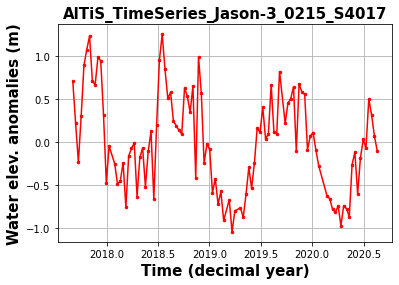

In [61]:
main()

1. Load coordinates in map DONE
2. Load lakes 
3. Load lakes gages sent to Denis DONE
4. Load hydrolakes SLOW (Change for only the lakes in the sublist)
5. Load all the lakes (Pending do the interception again in python)

In [38]:
#1.1 Coordinates from what Sylvain did
altis_path='../data/'
altis_fname='lonlat_vs_altis.csv'
df_altis=pd.read_csv(altis_path+altis_fname, sep=';')
#Convert to geodataframe
gdf_altis=gpd.GeoDataFrame(df_altis, geometry=gpd.points_from_xy(df_altis.lon, df_altis.lat))

#no need for the Dataframe anymore
del df_altis
gdf_altis.crs = 'epsg:4326'

#Load shapefile sent to Denis 
d_lakes_path='/home/angelica/Dropbox/Research/LOCSS/Denis_tracks/'
d_lakes_fname='lakes_to_denis_updated.shp'

gdf_dlakes=gpd.read_file(d_lakes_path+d_lakes_fname)

#hydrolakes in the lakes of interest TODO-LOAd only the relevant lakes for now
# hydrolakes_path='/home/angelica/Dropbox/Research/LOCSS/shapes/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/'
# hydrolakes_fname='HydroLakes_LT_10sk.shp'
# gdf_hydrolakes=gpd.read_file(hydrolakes_path+hydrolakes_fname)

#FROM HERE GO TO PLOT SPATIAL DATA

**Load time series**
1. Load argentina's Time series
2. Load loccss time series
3. Load other time series (Brazil)
4. Load VS time series 

In [45]:
def get_df_from_file(path, file_name):

    falti = path+file_name
    df=pd.read_csv(falti)
    df['file_name']=file_name
    return df

def get_array_from_file(path, file_name, col_date, col_height):

    falti = path+file_name
    
    #ncoldate = 'date'  # Same value for Sentinel-3A/B
    #ncolh = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
    # Load Altis Jason-3 altimetry time series
    (altiyear, altimonth, altiday, altihour, altiminute,
     altiwelev) = load_altis(falti, col_date, col_height)
    # Compute decimal year from year/month/day from altimetry time series
    d=(altiyear, altimonth, altiday, altihour, altiminute,
     altiwelev)
    
    altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                               altiyear, altimonth, altiday, altihour,
                               altiminute, np.zeros(altiday.shape))))
    
    return altidy

In [86]:
#4 Load VS time series 
#Get the list of the data
path_vs_ts='../data/alti_timeseries/'
postfix='.csv'
files = [f for f in os.listdir(path_vs_ts) if (os.path.isfile(os.path.join(path_vs_ts, f))&
                                                  (f.endswith(postfix)))]
df_final=pd.DataFrame()
for f in files:
    df=get_df_from_file(path_vs_ts,f)
    df_final=pd.concat([df_final, df], axis=0)

df_final.columns
df_gauge_ts=pd.read_csv('../data/sample_gauges_val_20220203.csv')
df_gauge_ts.gauge_id.unique()

array(['2028', 'KHB2', 'TAB2'], dtype=object)

In [93]:
print(df_vs_arg['date_dt'].min())#.head(1))
df_gauge_arg['date_dt'].head(1)
df_gauge_arg.columns

2016-03-12 03:14:00


Index(['date', 'height', 'gauge_id', 'Hylak_id', 'date_dt', 'alti_m',
       'file_name'],
      dtype='object')

In [145]:
# df_vs_arg=df_final.loc[(df_final['file_name']=='AlTiS_TimeSeries_Jason-3_0215_S4017.csv') |
#               (df_final['file_name']=='AlTiS_TimeSeries_Sentinel-3A_0749_S4016.csv')].copy()
df_vs_arg=df_final.loc[(df_final['file_name']=='AlTiS_TimeSeries_Sentinel-3A_0749_S4016.csv')].copy()
df_gauge_arg=df_gauge_ts.loc[df_gauge_ts['gauge_id']=='2028'].copy()
df_vs_arg.loc[:,'date_dt']=pd.to_datetime(df_vs_arg['date (Year-Month-Day hh:mm:ss)'])
df_vs_arg['date_dt']
df_gauge_arg.loc[:,'date_dt']=pd.to_datetime(df_gauge_arg['date'])
print(df_gauge_arg.shape)
df_gauge_arg=df_gauge_arg.loc[df_gauge_arg['date_dt']>=df_vs_arg['date_dt'].min()]
df_gauge_arg.shape
df_gauge_arg['date_dt'].min()
df_gauge_arg['alti_m']=df_gauge_arg['height']+643
df_gauge_arg['file_name']='ground_obs'
df_vs=df_vs_arg[['date_dt','ice2_ku_SurfHeight_alti_median (meters)', 'file_name' ]].copy()
df_vs=df_vs.rename(columns={'ice2_ku_SurfHeight_alti_median (meters)':'alti_m'})
df_gauge_arg=df_gauge_arg[['date_dt','alti_m','file_name']].copy()
df_gauge_arg
df_arg=pd.concat([df_vs,df_gauge_arg], axis=0)

(31001, 5)


file_name,date_dt,AlTiS_TimeSeries_Jason-3_0215_S4017.csv,AlTiS_TimeSeries_Sentinel-3A_0749_S4016.csv,ground_obs
0,2016-03-12 03:14:00,NaN,NaN,NaN
1,2016-03-12 16:00:00,NaN,NaN,644.22
2,2016-03-13 17:00:00,NaN,NaN,643.45
3,2016-03-14 17:00:00,NaN,NaN,643.44
4,2016-03-15 17:00:00,NaN,NaN,643.44
...,...,...,...,...
2102,2021-12-03 14:00:00,NaN,NaN,643.52
2103,2021-12-04 15:00:00,NaN,NaN,643.43
2104,2021-12-05 15:00:00,NaN,NaN,643.42
2105,2021-12-06 15:00:00,NaN,NaN,644.62


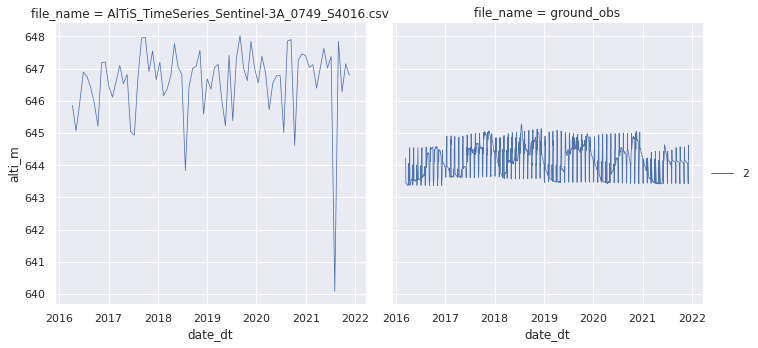

In [149]:

#df_arg

x_field='date_dt'
y_field='alti_m'
kind_plot='line'
hue='file_name'
#.loc[df_arg['file_name']=='ground_obs']
#sns.set(rc = {'figure.figsize':(25,15)})
sns.relplot(data=df_arg, x=x_field, y=y_field, kind=kind_plot, col=hue, size=2)
#plt.legend(bbox_to_anchor=(.02, 1),loc='lower center',borderaxespad=0)

In [140]:
df_vs_arg=df_final.loc[(df_final['file_name']=='AlTiS_TimeSeries_Sentinel-3A_0522_N2294.csv')].copy()# |
              #(df_final['file_name']=='AlTiS_TimeSeries_Sentinel-3A_0749_S4016.csv')].copy()
df_gauge_arg=df_gauge_ts.loc[df_gauge_ts['gauge_id']=='KHB2'].copy()
df_vs_arg.loc[:,'date_dt']=pd.to_datetime(df_vs_arg['date (Year-Month-Day hh:mm:ss)'])
df_vs_arg['date_dt']
df_gauge_arg.loc[:,'date_dt']=pd.to_datetime(df_gauge_arg['date'])
print(df_gauge_arg.shape)

df_gauge_arg.shape
if df_gauge_arg['date_dt'].min()<=df_vs_arg['date_dt'].min():
    df_gauge_arg=df_gauge_arg.loc[df_gauge_arg['date_dt']>=df_vs_arg['date_dt'].min()]
else: #df_gauge_arg['date_dt'].min()
    df_vs_arg=df_vs_arg.loc[df_vs_arg['date_dt']>=df_gauge_arg['date_dt'].min()]
df_gauge_arg['alti_m']=df_gauge_arg['height']#+643
df_gauge_arg['file_name']='ground_obs'
df_vs=df_vs_arg[['date_dt','ice2_ku_SurfHeight_alti_median (meters)', 'file_name' ]].copy()
df_vs=df_vs.rename(columns={'ice2_ku_SurfHeight_alti_median (meters)':'alti_m'})
df_gauge_arg=df_gauge_arg[['date_dt','alti_m','file_name']].copy()
df_gauge_arg
df_arg=pd.concat([df_vs,df_gauge_arg], axis=0)

(62, 5)


In [139]:
df_gauge_arg['date_dt'].min()
df_vs_arg['date_dt'].min()

Timestamp('2016-03-04 04:17:00')

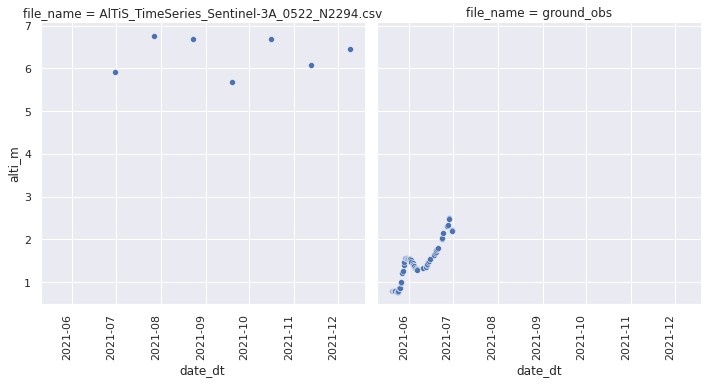

In [143]:
#df_arg

x_field='date_dt'
y_field='alti_m'
kind_plot='scatter'
hue='file_name'
#.loc[df_arg['file_name']=='ground_obs']
#sns.set(rc = {'figure.figsize':(25,15)})
g_n=sns.relplot(data=df_arg, x=x_field, y=y_field, kind=kind_plot, col=hue)#, facet_kws={'sharey': False, 'sharex': False})
g_n.set_xticklabels(rotation=90, horizontalalignment='right')
plt.show()

#plt.legend(bbox_to_anchor=(.02, 1),loc='lower center',borderaxespad=0)

In [53]:
#Plot spatial data lakes, gauges and virtual stations

m=gdf_altis.explore(name='VS from Sylvain', color='green')
gdf_dlakes[['Gauge ID', 'geometry']].explore(name='Lakes for Denis', color='red',
                   m=m)
#gdf_hydrolakes.explore(name='Hydrolakes', color='blue', m=m)
folium.TileLayer('OpenStreetMap', control=True).add_to(m) # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m

In [ ]:
main()